# Notebook Demo  
文章と式で説明してもわかりにくいので図を添えます。  
まずは色々設定します。    

In [1]:
%matplotlib inline
import numpy as np
import math, random                 # 計算用、乱数の生成用ライブラリ
import matplotlib.pyplot as plt # 描画用ライブラリ

In [2]:
class Landmarks:
    def __init__(self, array):
        self.positions = array # array = [[1個めの星のx座標, 1個めの星のy座標], [2個めの星のx座標, 2個めの星のy座標]...]
    
    def draw(self):
        # ランドマークの位置を取り出して描画
        xs = [e[0] for e in self.positions]
        ys = [e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

In [3]:
def Movement(pos, fw, rot):
    # 移動モデル
    # posからfw前進、rot回転した位置をリストで返す
    
    # 雑音の入った前進、回転の動き
    actual_fw = random.gauss(fw, fw * 0.2) # 20%の標準偏差でばらつく
    actual_rot = random.gauss(rot, rot * 0.2) # 20%の標準偏差でばらつく
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 3[deg]の標準偏差
    
    # 異動前の位置を保存
    px, py, pt = pos

    # 移動後の位置を計算
    x = px + actual_fw * math.cos(pt + dir_error)
    y = py + actual_fw * math.sin(pt + dir_error)
    t = pt + dir_error + actual_rot # dir_errorを足す

    # 結果を返す
    return [x,y,t]

In [4]:
def Observation(pos, landmark):
    # 観測モデル
    # posから見えるランドマークの距離と方向をリストで返す
    
    obss = []
    
    # センサの計測範囲
    # 距離0.1 ~ 1
    # 角度90 ~ -90[deg]
    sensor_max_range = 1.0
    sensor_min_range = 0.1
    sensor_max_angle = math.pi / 2
    sensor_min_angle = -math.pi / 2
    
    # ロボットやパーティクルの位置姿勢を保存
    rx, ry, rt = pos
    
    # ランドマークごとに観測
    for lpos in landmark.positions:
        true_lx, true_ly = lpos
        # 観測が成功したらresultをTrue
        result = True

        # ロボットとランドマークの距離を計算
        # センサの範囲外であればresultがFalseに
        distance = math.sqrt((rx - true_lx) ** 2 + (ry - true_ly) ** 2)
        if distance > sensor_max_range or distance < sensor_min_range:
            result = False

        # ロボットから見えるランドマークの方向を計算
        # こちらもセンサの範囲外であればresultがFalseに
        direction = math.atan2(true_ly - ry, true_lx - rx) - rt
        if direction > math.pi: direction -= 2 * math.pi
        if direction < - math.pi: direction += 2 * math.pi
        if direction > sensor_max_angle or direction < sensor_min_angle:
            result = False

        # 雑音の大きさを設定
        # これは尤度計算に使う正規分布関数の分散になる
        sigma_d = distance * 0.2 # 20%の標準偏差
        sigma_f = math.pi * 3 / 180 # 3degの標準偏差

        # 雑音を混ぜる
        d = random.gauss(distance, sigma_d)
        f = random.gauss(direction, sigma_f)
        
        # 観測データを保存
        z = []
        z.append([d, f, sigma_d, sigma_f, result])
        
    return z

In [5]:
class Robot:
    def __init__(self, x, y, rad):
        random.seed()
        
        # ステップごとにロボットの姿勢の真値が入った配列
        self.actual_poses = [[x,y,rad]]

    def move(self,fw,rot):
        # ロボットの位置を記録する(軌跡を残すために配列に入れてる)
        self.actual_poses.append(Movement(self.actual_poses[-1], fw, rot))
        
    def observation(self, landmarks):
        # 現在地から見た観測データの保存
        self.z = Observation(self.actual_poses[-1], landmarks)
        

    # 矢印の描画に必要な位置と方向を計算して描画
    def draw(self, sp):
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",scale=15,angles='xy',scale_units='xy',alpha = 0.3)

In [6]:
def draw(i):
    # グラフの設定
    fig = plt.figure(i, figsize=(8,8))
    sp = fig.add_subplot(111,aspect='equal')
    sp.set_xlim(-0.5,2.0)
    sp.set_ylim(-0.5,0.5)
    
    # ロボット、ランドマークの描画
    for robot in robots:
        robot.draw(sp)
    
    if i:
        for robot in robots:
            for obs in robot.z:
                d = obs[0]
                f = obs[1]
                x = d * math.cos(f)
                y = d * math.sin(f)
                plt.plot(x, y, "o")
    
    actual_landmarks.draw()
    
    plt.legend()

## 移動モデル  
ロボットを100台出してみます。  
どのロボットも1前進という命令を出しましたが、バラバラしていることがわかります。  

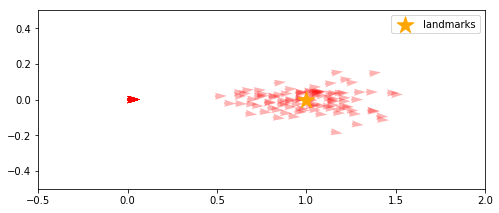

In [7]:
actual_landmarks = Landmarks([[1.0,0.0]])
robots = []

for i in range(100):
    robots.append(Robot(0,0,0))

for robot in robots:
    robot.move(1.0, 0)
    
draw(0)

## 観測モデル  
同様にロボットを100台出して、1先に見える星を観測させます。  
カラフルなドットがロボットから見える星の位置です。  

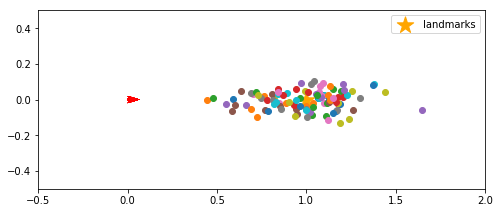

In [8]:
actual_landmarks = Landmarks([[1.0,0.0]])
robots = []

for i in range(100):
    robots.append(Robot(0,0,0))
    
for robot in robots:
    robot.observation(actual_landmarks)
    
draw(1)

## 尤度計算  
今回は尤度計算に正規分布を使っています。  
ロボットの観測データ$d, \varphi$と、パーティクルの観測データ$d', \varphi'$の差が大きいほど小さな値になります。  

$$
p(z|x_t) \propto \frac {\exp (- \frac {1}{2\sigma_d}(d-d')^2)}{\sigma_d \sqrt{2 \pi}} \frac {\exp (- \frac {1}{2\sigma_\varphi}(\varphi-\varphi')^2)}{\sigma_\varphi \sqrt{2 \pi}}
$$
  
下のグラフは$d$と$\varphi$についてそれぞれ別々に描画した正規分布のグラフです。  
$d$がオレンジ、$\varphi$が青のグラフです。  
上の観測モデルと同じように、ランドマークはロボットから見て、0°の向きに1離れた位置にあります。  
なので$d$、distanceのグラフは、1に近いほど値が大きく、$\varphi$、directionのグラフは0に近いほど値が大きくなっています。  

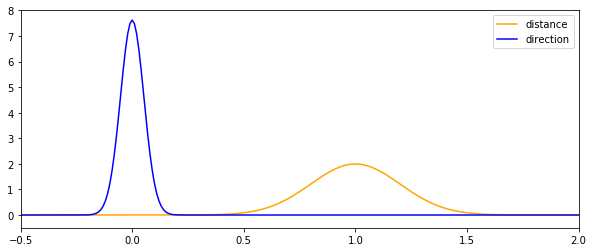

In [58]:
rd = 1
rf = 0
sigma_rd = 1.0 * 0.2
sigma_rf = math.pi * 3 / 180

pd = np.arange(-3, 3, 0.01)
pf = np.arange(-3, 3, 0.01)

d = np.exp(-(rd - pd) ** 2 / (2 * (sigma_rd ** 2))) / (sigma_rd * np.sqrt(2 * np.pi))
f = np.exp(-(rf - pf) ** 2 / (2 * (sigma_rf ** 2))) / (sigma_rf * np.sqrt(2 * np.pi))

fig = plt.figure(figsize=(10,4))
sp = fig.add_subplot(111)
sp.set_xlim(-0.5,2.0)
sp.set_ylim(-0.5,8)

plt.plot(pd, d, color = "orange",label="distance")
plt.plot(pf, f, color = "blue",label="direction")

plt.legend()